<a href="https://colab.research.google.com/github/my-tech123/Assignment-5/blob/main/5ass_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.6 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


✅ Datasets saved locally!



📊 Performance Comparison:
    Dataset   HMM_RMSE  HMM_MAPE  LSTM_RMSE  LSTM_MAPE
0  Weather   0.612488  1.970115   3.196741  10.907130
1    Stock  71.575886  4.566427  80.854981   5.106351


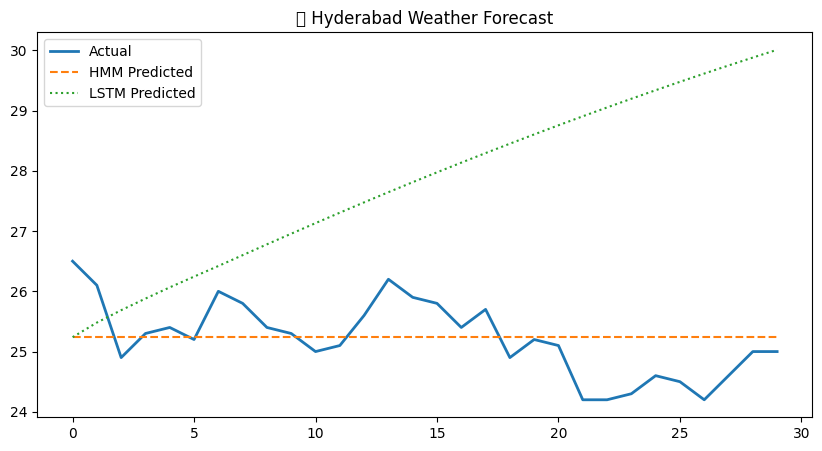

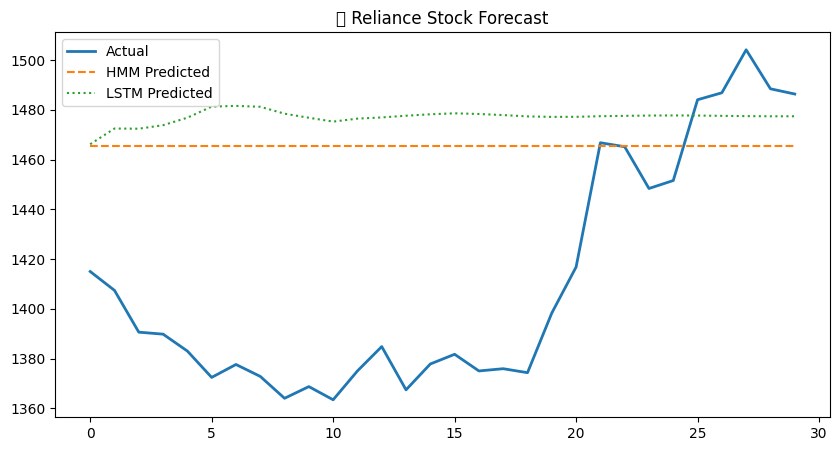

In [1]:
# ============================================================
# 📘 HMM vs LSTM Forecasting on Real Datasets
# Datasets: Hyderabad Weather + Reliance Stock
# ============================================================

!pip install meteostat yfinance hmmlearn tensorflow numpy pandas scikit-learn matplotlib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from hmmlearn.hmm import GaussianHMM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from meteostat import Point, Daily
from datetime import datetime
import yfinance as yf

# -------------------------------
# 1️⃣ Load or fetch both datasets
# -------------------------------

# Weather data (Hyderabad)
start = datetime(2023, 1, 1)
end = datetime.now()
hyderabad = Point(17.3850, 78.4867)
weather = Daily(hyderabad, start, end).fetch()
weather.to_csv("hyderabad_weather.csv")

# Stock data (Reliance)
reliance = yf.download("RELIANCE.NS", period="1y", interval="1d")
reliance.to_csv("reliance_stock.csv")

print("✅ Datasets saved locally!")

# -------------------------------
# 2️⃣ Preprocess data
# -------------------------------

def prepare_series(df, colname):
    series = df[colname].fillna(method='ffill')
    series = np.array(series)
    return series

weather_target = prepare_series(weather, "tavg")
stock_target = prepare_series(reliance, "Close")

# -------------------------------
# 3️⃣ HMM Modeling
# -------------------------------

def hmm_forecast(series, n_states=4, n_preds=10):
    X = np.column_stack([series[:-1], series[1:]])
    model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000)
    model.fit(X)
    hidden_states = model.predict(X)

    # Forecast last state trend
    last_state = hidden_states[-1]
    means = np.array([model.means_[i][1] for i in range(n_states)])
    preds = [means[last_state]] * n_preds
    return np.array(preds)

# -------------------------------
# 4️⃣ LSTM Modeling
# -------------------------------

def lstm_forecast(series, lookback=10, n_preds=10, epochs=30):
    # Prepare sequences
    X, y = [], []
    for i in range(len(series)-lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(lookback, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=16, verbose=0)

    # Forecast next n steps
    preds = []
    last_seq = series[-lookback:]
    for _ in range(n_preds):
        x_input = last_seq.reshape((1, lookback, 1))
        yhat = model.predict(x_input, verbose=0)
        preds.append(yhat[0,0])
        last_seq = np.append(last_seq[1:], yhat)
    return np.array(preds)

# -------------------------------
# 5️⃣ Evaluation Metrics
# -------------------------------

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true).reshape(-1), np.array(y_pred).reshape(-1)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# -------------------------------
# 6️⃣ Run Forecasting & Evaluation
# -------------------------------

n_preds = 30

# Weather Forecast
hmm_weather_preds = hmm_forecast(weather_target, n_preds=n_preds)
lstm_weather_preds = lstm_forecast(weather_target, n_preds=n_preds)

# Stock Forecast
hmm_stock_preds = hmm_forecast(stock_target, n_preds=n_preds)
lstm_stock_preds = lstm_forecast(stock_target, n_preds=n_preds)

# Align for metrics
actual_weather = weather_target[-n_preds:]
actual_stock = stock_target[-n_preds:]

# Metrics
results = {
    "Dataset": ["Weather", "Stock"],
    "HMM_RMSE": [rmse(actual_weather, hmm_weather_preds), rmse(actual_stock, hmm_stock_preds)],
    "HMM_MAPE": [mape(actual_weather, hmm_weather_preds), mape(actual_stock, hmm_stock_preds)],
    "LSTM_RMSE": [rmse(actual_weather, lstm_weather_preds), rmse(actual_stock, lstm_stock_preds)],
    "LSTM_MAPE": [mape(actual_weather, lstm_weather_preds), mape(actual_stock, lstm_stock_preds)],
}
metrics_df = pd.DataFrame(results)
print("\n📊 Performance Comparison:\n", metrics_df)

# -------------------------------
# 7️⃣ Plot Comparison
# -------------------------------

def plot_results(actual, hmm_pred, lstm_pred, title):
    plt.figure(figsize=(10,5))
    plt.plot(actual, label="Actual", linewidth=2)
    plt.plot(hmm_pred, label="HMM Predicted", linestyle='--')
    plt.plot(lstm_pred, label="LSTM Predicted", linestyle=':')
    plt.title(title)
    plt.legend()
    plt.show()

plot_results(actual_weather, hmm_weather_preds, lstm_weather_preds, "🌦 Hyderabad Weather Forecast")
plot_results(actual_stock, hmm_stock_preds, lstm_stock_preds, "💹 Reliance Stock Forecast")
